In [1]:
import os
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from eunjeon import Mecab
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Bidirectional
from gensim.models import Word2Vec

plt.rc('font', family='Malgun Gothic')


In [2]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
data_dir = '../analysis_files/files/'
data_dir2 = '../analysis_files/word2vec/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# mecab 모델 다운로드
tokenizer = Mecab()

In [4]:
def load_dataset(data_dir):
    df = pd.read_csv(os.path.join(data_dir, '감성대화말뭉치(최종데이터)_Validation.csv'), encoding='cp949')
    df = df[['사람문장1', '감정_대분류', '상황키워드']]

    # NaN values and empty strings removal
    df.dropna(subset=['사람문장1'], inplace=True)
    df = df[df.astype(str).ne('').all(axis=1)]

    # Label encoding
    emotion_encoder = LabelEncoder()
    df['emotion'] = emotion_encoder.fit_transform(df['감정_대분류'])
    situation_encoder = LabelEncoder()
    df['situation'] = situation_encoder.fit_transform(df['상황키워드'])

    # Create label mapping dictionaries
    emotion_mapping = dict(zip(emotion_encoder.classes_, emotion_encoder.transform(emotion_encoder.classes_)))
    situation_mapping = dict(zip(situation_encoder.classes_, situation_encoder.transform(situation_encoder.classes_)))

    # Data split
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)
    
    return train_df, test_df, emotion_mapping, situation_mapping

In [5]:
train_df, test_df, emotion_mapping, situation_mapping = load_dataset(data_dir)

# Print the label mappings
print("Emotion Label Mapping:")
for emotion, encoded_label in emotion_mapping.items():
    print(f"{emotion}: {encoded_label}")

print("\nSituation Label Mapping:")
for situation, encoded_label in situation_mapping.items():
    print(f"{situation}: {encoded_label}")

Emotion Label Mapping:
기쁨: 0
당황: 1
분노: 2
불안: 3
상처: 4
슬픔: 5

Situation Label Mapping:
가족관계: 0
건강: 1
건강,죽음: 2
대인관계: 3
대인관계(부부, 자녀): 4
연애,결혼,출산: 5
재정: 6
재정,은퇴,노후준비: 7
직장, 업무 스트레스: 8
진로,취업,직장: 9
학교폭력/따돌림: 10
학업 및 진로: 11


In [6]:
train_df.head()

,사람문장1,감정_대분류,상황키워드,emotion,situation
1468,아이들 키우느라 은퇴 준비를 별도로 마련하지 못했는데 하루아침에 갑자기 해고 통지를...,불안,재정,3,6
4857,생각보다 빨리 은퇴를 해야 할 것 같은데 준비를 어떻게 해야 할지 당혹스러워.,불안,"재정,은퇴,노후준비",3,7
2166,나는 엄마를 요양원에 보내자는 언니의 말에 찬성하지 않아.,불안,대인관계,3,3
5010,오늘 학교가 개교기념일이어서 공부를 하지 않아서 좋아.,기쁨,학업 및 진로,0,11
3808,회사의 업무 부조리에 대해 개선을 요구했는데 그것 때문에 따돌림을 받게 되었어.,상처,"직장, 업무 스트레스",4,8


In [7]:
utterance_train = train_df['사람문장1'].tolist()
label_emotion_train = train_df['emotion'].tolist()
label_situation_train = train_df['situation'].tolist()
utterance_test = test_df['사람문장1'].tolist()
label_emotion_test = test_df['emotion'].tolist()
label_situation_test = test_df['situation'].tolist()

print('훈련용 문장의 수 :', len(utterance_train))
print('훈련용 감정레이블의 수 :', len(label_emotion_train))
print('훈련용 원인레이블의 수 :', len(label_situation_train))
print('테스트용 문장의 수 :', len(utterance_test))
print('테스트용 감정레이블의 수 :', len(label_emotion_test))
print('테스트용 원인레이블의 수 :', len(label_situation_test))

훈련용 문장의 수 : 5976
훈련용 감정레이블의 수 : 5976
훈련용 원인레이블의 수 : 5976
테스트용 문장의 수 : 665
테스트용 감정레이블의 수 : 665
테스트용 원인레이블의 수 : 665


<Axes: xlabel='감정_대분류'>

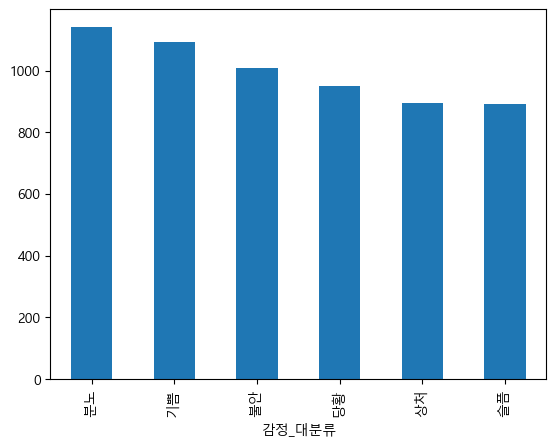

In [8]:
train_df['감정_대분류'].value_counts().plot(kind = 'bar')

<Axes: xlabel='감정_대분류'>

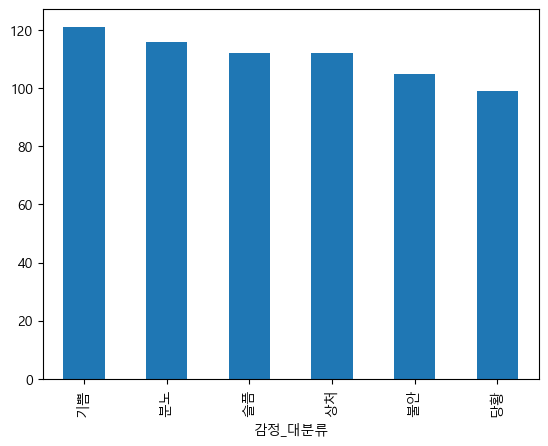

In [9]:
test_df['감정_대분류'].value_counts().plot(kind = 'bar')

<Axes: xlabel='상황키워드'>

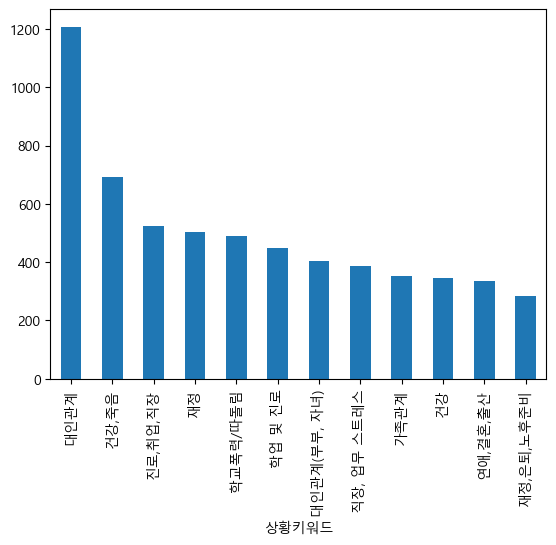

In [10]:
train_df['상황키워드'].value_counts().plot(kind = 'bar')

<Axes: xlabel='상황키워드'>

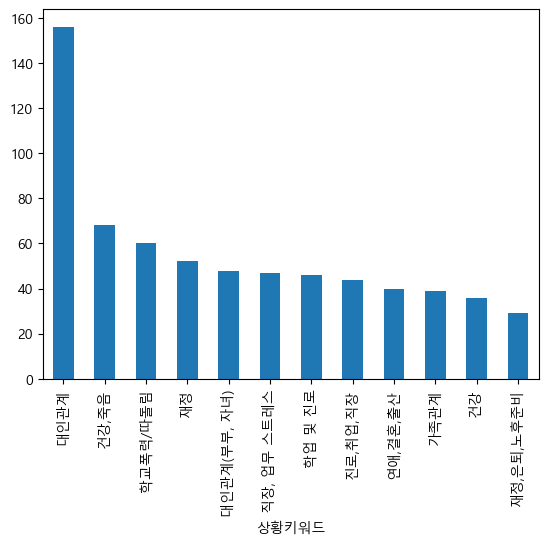

In [11]:
test_df['상황키워드'].value_counts().plot(kind = 'bar')

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['사람문장1'].tolist())
sequences_train = tokenizer.texts_to_sequences(train_df['사람문장1'].tolist())
sequences_test = tokenizer.texts_to_sequences(test_df['사람문장1'].tolist())
sequences_train[:5] # 상위 5개 샘플 출력

[[1838,
  1839,
  213,
  152,
  5141,
  3155,
  3156,
  1840,
  58,
  2307,
  3157,
  261,
  5142,
  5143,
  900],
 [507, 182, 539, 75, 56, 6, 508, 152, 73, 75, 111, 336],
 [12, 1841, 1132, 5144, 2308, 741, 5145, 29],
 [17, 1842, 5146, 189, 138, 94, 52],
 [1133, 292, 5147, 144, 5148, 5149, 5150, 13, 159, 477, 248]]

In [13]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 14517


문장의 최대 길이 : 27
문장의 평균 길이 : 9.667838018741634


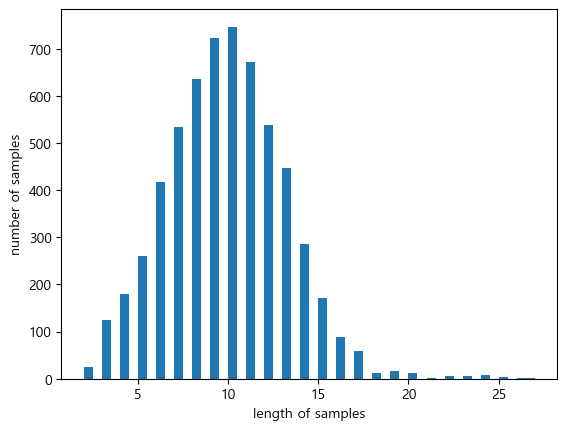

In [14]:
print('문장의 최대 길이 :',max(len(l) for l in sequences_train))
print('문장의 평균 길이 :',sum(map(len, sequences_train))/len(sequences_train))
plt.hist([len(s) for s in sequences_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
max_len = 30

utterance_train = pad_sequences(sequences_train, maxlen=max_len)
utterance_test = pad_sequences(sequences_test, maxlen=max_len)

label_emotion_train = to_categorical(train_df['emotion'])
label_situation_train = to_categorical(train_df['situation'])
label_emotion_test = to_categorical(test_df['emotion'])
label_situation_test = to_categorical(test_df['situation'])

print('훈련 데이터의 크기(shape):', utterance_train.shape)
print('훈련 데이터 감정레이블의 크기(shape):', label_emotion_train.shape)
print('훈련 데이터 원인레이블의 크기(shape):', label_situation_train.shape)

훈련 데이터의 크기(shape): (5976, 30)
훈련 데이터 감정레이블의 크기(shape): (5976, 6)
훈련 데이터 원인레이블의 크기(shape): (5976, 12)


In [16]:
print('훈련 데이터의 첫번째 샘플 :',utterance_train[0])
print('훈련 데이터의 첫번째 샘플의 감정레이블 :',label_emotion_train[0])
print('훈련 데이터의 첫번째 샘플의 원인레이블 :',label_situation_train[0])

훈련 데이터의 첫번째 샘플 : [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 1838 1839  213  152 5141 3155 3156 1840   58 2307 3157  261 5142
 5143  900]
훈련 데이터의 첫번째 샘플의 감정레이블 : [0. 0. 0. 1. 0. 0.]
훈련 데이터의 첫번째 샘플의 원인레이블 : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [17]:
indices_train = np.arange(utterance_train.shape[0])
np.random.shuffle(indices_train)
print('랜덤 시퀀스 :',indices_train)

indices_test = np.arange(utterance_test.shape[0])
np.random.shuffle(indices_test)

랜덤 시퀀스 : [5403 3610 3627 ... 2307 2215 1727]


In [18]:
X_train = utterance_train[indices_train]
y_emotion_train = label_emotion_train[indices_train]
y_situation_train = label_situation_train[indices_train]

X_test = utterance_test[indices_test]
y_emotion_test = label_emotion_test[indices_test]
y_situation_test = label_situation_test[indices_test]

In [19]:
embedding_dict = dict()
# 사전 훈련된 Word2Vec 모델을 로드
model = Word2Vec.load(os.path.join(data_dir2, 'ko.bin'))

In [20]:
for word in model.wv.vocab:
    embedding_dict[word] = model.wv[word]
    
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

30185개의 Embedding vector가 있습니다.


In [21]:
print(embedding_dict['우울'])
print(len(embedding_dict['우울']))

[-1.21498978e+00 -5.43866694e-01  1.32688725e+00 -6.49432898e-01
 -4.38877225e-01  5.52123845e-01  4.83556360e-01  1.02437699e+00
 -2.07902670e-01  1.21977139e+00 -5.29723316e-02  2.83519924e-01
  3.75814110e-01  6.29925787e-01 -5.16617894e-01 -2.62273163e-01
 -1.77138105e-01  7.17207134e-01  1.64666355e-01 -1.71311915e-01
  5.11819899e-01  4.22978140e-02  2.26164639e-01  7.59881958e-02
  3.07586491e-01  6.97090849e-02 -4.44131732e-01  9.51295376e-01
 -9.61420715e-01 -3.31237733e-01  3.33495051e-01 -2.93511562e-02
  4.39231545e-01  2.65127450e-01 -3.65351290e-01 -7.63717890e-01
  7.36222565e-02 -9.49564651e-02  2.45211333e-01  6.11337125e-01
 -1.75878897e-01  6.61108434e-01  1.19337216e-02 -8.98760736e-01
  9.82642323e-02  5.10104120e-01 -3.21627408e-01  2.17479408e-01
  3.48298520e-01  1.51318341e-01 -2.26444125e-01  3.23872238e-01
 -6.18719637e-01  9.16367769e-01 -7.72069275e-01 -2.47000799e-01
 -4.40212220e-01  1.47606462e-01  2.45241672e-01  6.81707561e-01
 -1.40714899e-01  3.91073

In [22]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print('임베딩 테이블의 크기(shape) :',np.shape(embedding_matrix))


임베딩 테이블의 크기(shape) : (14517, 200)


In [23]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=size,
                         padding="valid",
                         activation="relu",
                         strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)



In [25]:
# Emotion classification model
num_emotion_classes = len(emotion_mapping)
model_output_emotion = Dense(num_emotion_classes, activation='softmax')(output)
model_emotion = Model(model_input, model_output_emotion)

model_emotion.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_emotion.summary()

history_emotion = model_emotion.fit(X_train, y_emotion_train,
                                    batch_size=32,
                                    epochs=20,
                                    validation_data=(X_test, y_emotion_test))

# 학습된 모델 저장
model_emotion.save('emotion_classification_model.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 200)              2903400   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 29, 512)              205312    ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 28, 512)              307712    ['embedding[0][0]']           
                                                                                              

c:\Users\User\anaconda3\envs\torch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
# 데이터 다시 0.9/0.1로 분할
X_train_new, X_test_new, y_emotion_train_new, y_emotion_test_new = train_test_split(
    X_train, y_emotion_train, test_size=0.2, random_state=42
)

In [27]:
# 모델 초기화
num_emotion_classes = len(emotion_mapping)
model_output_emotion = Dense(num_emotion_classes, activation='softmax')(output)
model_emotion = Model(model_input, model_output_emotion)

model_emotion.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# 저장한 학습된 모델 불러오기
model_emotion.load_weights('emotion_classification_model.h5')

# 모델을 다시 학습
history_emotion_new = model_emotion.fit(X_train_new, y_emotion_train_new,
                                        batch_size=32,
                                        epochs=20,
                                        validation_data=(X_test_new, y_emotion_test_new))

# 학습된 모델을 사용하여 예측값을 계산합니다.
y_emotion_pred = model_emotion.predict(X_test_new)
y_emotion_pred_classes = np.argmax(y_emotion_pred, axis=1)  # One-hot 인코딩에서 클래스로 변환

# 정확도(Accuracy) 계산
accuracy = accuracy_score(np.argmax(y_emotion_test_new, axis=1), y_emotion_pred_classes)

# Recall 계산 (macro 평균)
recall = recall_score(np.argmax(y_emotion_test_new, axis=1), y_emotion_pred_classes, average='macro')

# F1-score 계산 (macro 평균)
f1 = f1_score(np.argmax(y_emotion_test_new, axis=1), y_emotion_pred_classes, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Epoch 1/20
169/169 [==============================] - 4s 18ms/step - loss: 1.0944 - acc: 0.6114 - val_loss: 0.9079 - val_acc: 0.6739
Epoch 2/20
169/169 [==============================] - 3s 17ms/step - loss: 1.0757 - acc: 0.6305 - val_loss: 0.9845 - val_acc: 0.6589
Epoch 3/20
169/169 [==============================] - 3s 17ms/step - loss: 1.0586 - acc: 0.6359 - val_loss: 1.0360 - val_acc: 0.6204
Epoch 4/20
169/169 [==============================] - 3s 18ms/step - loss: 1.0094 - acc: 0.6514 - val_loss: 1.1545 - val_acc: 0.5870
Epoch 5/20
169/169 [==============================] - 3s 18ms/step - loss: 0.9855 - acc: 0.6640 - val_loss: 1.1194 - val_acc: 0.5987
Epoch 6/20
169/169 [==============================] - 3s 17ms/step - loss: 1.0021 - acc: 0.6543 - val_loss: 1.2129 - val_acc: 0.5552
Epoch 7/20
169/169 [==============================] - 3s 17ms/step - loss: 0.9714 - acc: 0.6633 - val_loss: 1.3938 - val_acc: 0.5502
Epoch 8/20
169/169 [==============================] - 3s 17ms/step - 

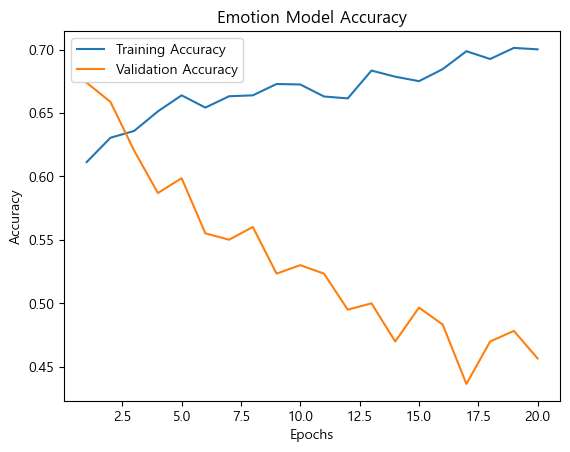

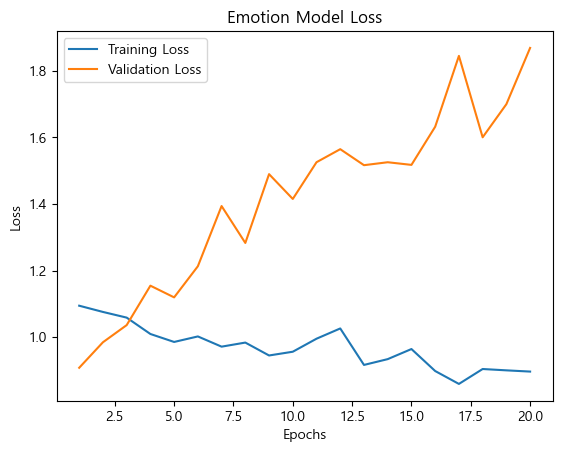

In [28]:
# Training and validation accuracy
epochs = range(1, len(history_emotion_new.history['acc']) + 1)
plt.plot(epochs, history_emotion_new.history['acc'], label='Training Accuracy')
plt.plot(epochs, history_emotion_new.history['val_acc'], label='Validation Accuracy')
plt.title('Emotion Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training and validation loss
plt.plot(epochs, history_emotion_new.history['loss'], label='Training Loss')
plt.plot(epochs, history_emotion_new.history['val_loss'], label='Validation Loss')
plt.title('Emotion Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()